# Preparing the Dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]

)

In [ ]:
batch_size = 64
random_seed = 42
learning_rate = 0.01
momentum = 0.5
n_epochs = 100
log_interval = 10

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)
test_data = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data,test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [ ]:
import pickle
meta_file = open ("/content/data/cifar-10-batches-py/batches.meta","rb")
meta_data = pickle.load(meta_file)
print(meta_data)

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


In [ ]:
print('Label Names:',meta_data['label_names'])

Label Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')

In [ ]:
df = enumerate(test_loader)
batch_idx, (df_data, df_targets) = next(df)

In [ ]:
df_data.shape

torch.Size([64, 3, 32, 32])

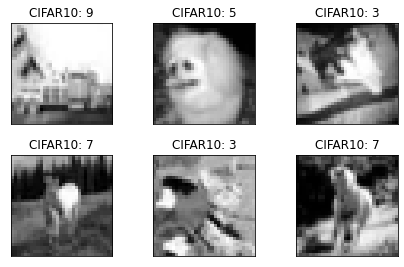

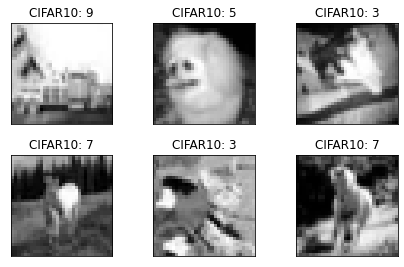

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(df_data[i][0], cmap='gray', interpolation='none')
  plt.title("CIFAR10: {}".format(df_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Building the Network 


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 66, kernel_size=3)#66*32*32
        self.conv2 = nn.Conv2d(66, 128, kernel_size=3)#128*16*16
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)#256*4*4
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1024, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        #print(x.shape)
       
        x = x.view(-1, 1024)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
#rand_input=torch.randn(1000,3,32,32)
#net=Net()
#out=net(rand_input)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training the Model

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(test_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-13-607b7afa94be>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.293885
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.314802
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.331698
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.294696
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.305594
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.331045
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.310113
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.301385
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.299248
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.303447
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.309743
Train Epoch: 1 [7040/50000 (14%)]	Loss: 2.291974
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.287390
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.288300
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.304815
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.308224
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.299649
Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.299418
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.287773
Train Epoch: 1 [12160/50000 (24%)]	Loss: 2.308612
Train Epoch: 1 [12800/50000 

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
Train Epoch: 40 [1280/50000 (3%)]	Loss: 0.497197
Train Epoch: 40 [1920/50000 (4%)]	Loss: 0.528438
Train Epoch: 40 [2560/50000 (5%)]	Loss: 0.682703
Train Epoch: 40 [3200/50000 (6%)]	Loss: 0.666353
Train Epoch: 40 [3840/50000 (8%)]	Loss: 0.626340
Train Epoch: 40 [4480/50000 (9%)]	Loss: 0.504800
Train Epoch: 40 [5120/50000 (10%)]	Loss: 0.473361
Train Epoch: 40 [5760/50000 (12%)]	Loss: 0.753879
Train Epoch: 40 [6400/50000 (13%)]	Loss: 0.533089
Train Epoch: 40 [7040/50000 (14%)]	Loss: 0.447002
Train Epoch: 40 [7680/50000 (15%)]	Loss: 0.979543
Train Epoch: 40 [8320/50000 (17%)]	Loss: 0.837778
Train Epoch: 40 [8960/50000 (18%)]	Loss: 0.643117
Train Epoch: 40 [9600/50000 (19%)]	Loss: 0.693799
Train Epoch: 40 [10240/50000 (20%)]	Loss: 0.866660
Train Epoch: 40 [10880/50000 (22%)]	Loss: 0.586667
Train Epoch: 40 [11520/50000 (23%)]	Loss: 0.439355
Train Epoch: 40 [12160/50000 (24%)]	Loss: 0.700147
Train Epoch: 40 [12800/50000 (26%)]	Loss: 0.753461


# Evaluating the Model's Performance

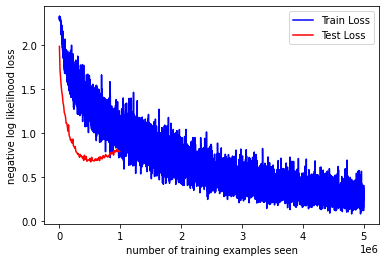

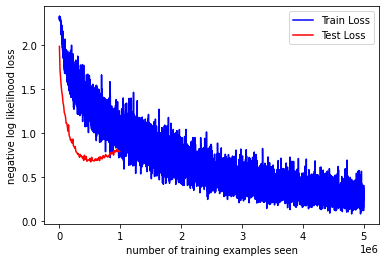

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig